c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading dataset...
Loaded 18846 documents.

Vectorizing with TF-IDF...
TF-IDF matrix shape: (18846, 5000)

Running Baseline Classification...
Training baseline model: Logistic Regression
Training baseline model: Linear SVM
Training baseline model: kNN

=== Baseline Results ===
Logistic Regression: Accuracy=0.6999, F1=0.6887
Linear SVM: Accuracy=0.6882, F1=0.6810
kNN: Accuracy=0.1266, F1=0.1267

Running PCA...

Running NMF...

Running UMAP...

Running t-SNE for 2D Visualization...


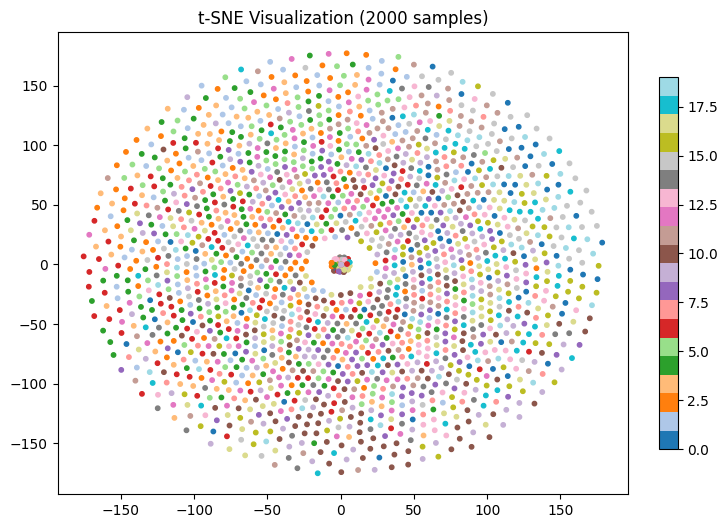



=== ALL RESULTS (Baseline + DR) ===


,Method,n_components,Classifier,Accuracy,F1,Time
0,PCA,10,Logistic Regression,0.416519,0.381803,2.660557
1,PCA,10,Linear SVM,0.392996,0.383778,2.660557
2,PCA,10,kNN,0.396710,0.386262,2.660557
3,PCA,50,Logistic Regression,0.577644,0.556479,4.250067
4,PCA,50,Linear SVM,0.559250,0.547903,4.250067
5,PCA,50,kNN,0.483375,0.474809,4.250067
6,PCA,100,Logistic Regression,0.623452,0.603271,7.265541
7,PCA,100,Linear SVM,0.605589,0.594826,7.265541
8,PCA,100,kNN,0.484966,0.483334,7.265541
9,NMF,10,Logistic Regression,0.315706,0.230536,3.256705


In [ ]:
# ================================================================
#  20 NEWSGROUPS — FULL WORKFLOW
# ================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import silhouette_score
import time
import warnings
warnings.filterwarnings("ignore")

# ================================================================
# 1. LOAD DATASET
# ================================================================
print("Loading dataset...")
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
X_text = newsgroups.data
y = newsgroups.target
target_names = newsgroups.target_names

print("Loaded", len(X_text), "documents.")

# ================================================================
# 2. TF-IDF VECTORIZATION
# ================================================================
print("\nVectorizing with TF-IDF...")
vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,            # limit vocab for speed
    max_df=0.7,
    min_df=5
)
X = vectorizer.fit_transform(X_text)

print("TF-IDF matrix shape:", X.shape)

# ================================================================
# 3. TRAIN-TEST SPLIT
# ================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# ================================================================
# Helper Functions
# ================================================================
def evaluate_model(model, X_train, X_test, y_train, y_test):
    """Train classifier + return accuracy and F1."""
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds), f1_score(y_test, preds, average='macro')


def trustworthiness_score(X_original, X_embedded, n_neighbors=10):
    """Compute Trustworthiness metric."""
    # sklearn's trustworthiness exists but limited — implement manual approach
    from sklearn.manifold import trustworthiness
    return trustworthiness(X_original, X_embedded, n_neighbors=n_neighbors)

def plot_2d(X_2d, labels, title):
    """Scatter plot for 2D embeddings."""
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='tab20', s=10)
    plt.title(title)
    plt.colorbar(scatter, fraction=0.03)
    plt.show()

# ================================================================
# 4. BASELINE CLASSIFICATION (NO DIMENSIONALITY REDUCTION)
# ================================================================
print("\nRunning Baseline Classification...")

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Linear SVM": SVC(kernel='linear'),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

baseline_results = {}

for name, model in models.items():
    print(f"Training baseline model: {name}")
    acc, f1 = evaluate_model(model, X_train, X_test, y_train, y_test)
    baseline_results[name] = (acc, f1)

print("\n=== Baseline Results ===")
for name, (acc, f1) in baseline_results.items():
    print(f"{name}: Accuracy={acc:.4f}, F1={f1:.4f}")

# ================================================================
# 5. DIMENSIONALITY REDUCTION CONFIG
# ================================================================
N_COMPONENTS_LIST = [10, 50, 100]

results = []

# ================================================================
# 6. LINEAR DR — PCA
# ================================================================
print("\nRunning PCA...")
for n in N_COMPONENTS_LIST:
    pca = PCA(n_components=n)
    t0 = time.time()
    X_train_pca = pca.fit_transform(X_train.toarray())
    X_test_pca = pca.transform(X_test.toarray())
    dt = time.time() - t0

    # Evaluate classifiers after PCA
    for name, model in models.items():
        acc, f1 = evaluate_model(model, X_train_pca, X_test_pca, y_train, y_test)
        results.append(["PCA", n, name, acc, f1, dt])

# ================================================================
# 7. LINEAR DR — NMF (Non-negative data)
# ================================================================
print("\nRunning NMF...")
for n in N_COMPONENTS_LIST:
    nmf = NMF(n_components=n, init='nndsvda')
    t0 = time.time()
    X_train_nmf = nmf.fit_transform(X_train)
    X_test_nmf = nmf.transform(X_test)
    dt = time.time() - t0

    for name, model in models.items():
        acc, f1 = evaluate_model(model, X_train_nmf, X_test_nmf, y_train, y_test)
        results.append(["NMF", n, name, acc, f1, dt])

# ================================================================
# 8. NONLINEAR DR — UMAP
# ================================================================
print("\nRunning UMAP...")
for n in [10, 50]:
    reducer = umap.UMAP(n_components=n, random_state=42)
    t0 = time.time()
    X_train_umap = reducer.fit_transform(X_train)
    X_test_umap = reducer.transform(X_test)
    dt = time.time() - t0

    for name, model in models.items():
        acc, f1 = evaluate_model(model, X_train_umap, X_test_umap, y_train, y_test)
        results.append(["UMAP", n, name, acc, f1, dt])

# ================================================================
# 9. NONLINEAR DR — t-SNE (Visualization Only)
# ================================================================
print("\nRunning t-SNE for 2D Visualization...")
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_sample = X_train[:2000].toarray()   # use small subset
y_sample = y_train[:2000]

X_tsne = tsne.fit_transform(X_sample)
plot_2d(X_tsne, y_sample, "t-SNE Visualization (2000 samples)")

# ================================================================
# 10. SHOW RESULTS TABLE
# ================================================================
df = pd.DataFrame(results, columns=[
    "Method", "n_components", "Classifier", "Accuracy", "F1", "Time"
])

print("\n\n=== ALL RESULTS (Baseline + DR) ===")
display(df)


Generating visualizations...


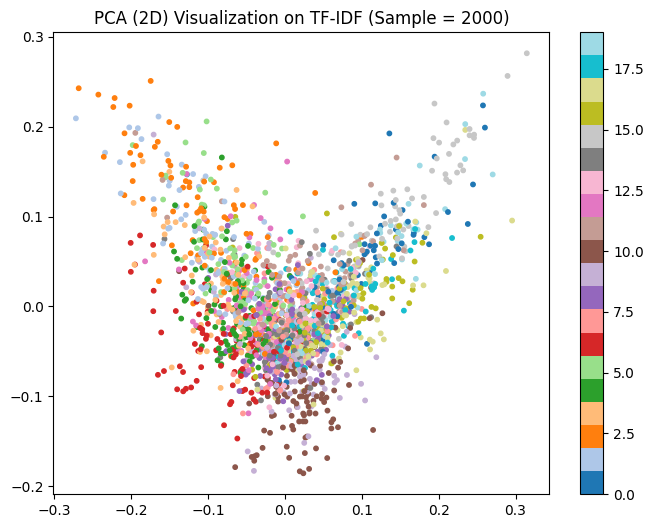

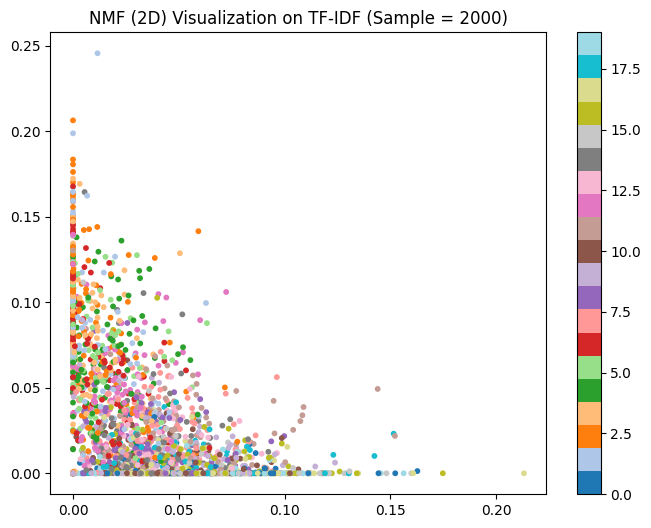

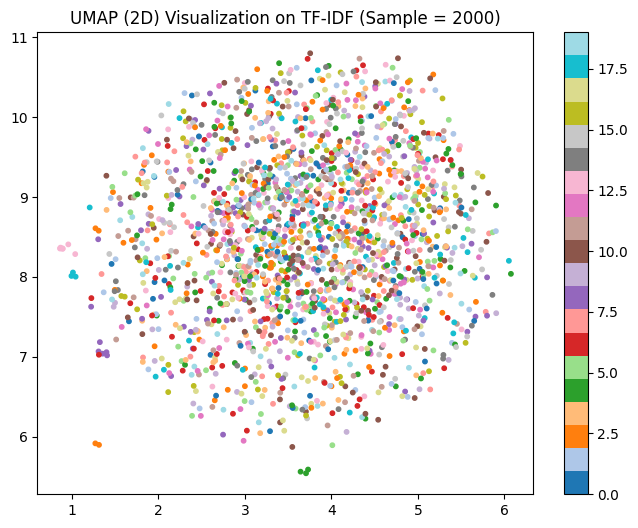

All visualizations completed.


In [2]:
# ================================================================
# ADDITIONAL VISUALIZATIONS FOR PCA, NMF, AND UMAP
# ================================================================

from sklearn.decomposition import PCA
import umap
from sklearn.decomposition import NMF

print("Generating visualizations...")

# Take smaller sample for plotting (avoid lag)
X_vis = X_train[:2000].toarray()
y_vis = y_train[:2000]

# ---------- PCA Visualization ----------
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_vis)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_vis, cmap="tab20", s=10)
plt.title("PCA (2D) Visualization on TF-IDF (Sample = 2000)")
plt.colorbar()
plt.show()

# ---------- NMF Visualization ----------
nmf_2d = NMF(n_components=2, init="nndsvda")
X_nmf_2d = nmf_2d.fit_transform(X_vis)

plt.figure(figsize=(8, 6))
plt.scatter(X_nmf_2d[:, 0], X_nmf_2d[:, 1], c=y_vis, cmap="tab20", s=10)
plt.title("NMF (2D) Visualization on TF-IDF (Sample = 2000)")
plt.colorbar()
plt.show()

# ---------- UMAP Visualization ----------
umap_2d = umap.UMAP(n_components=2, random_state=42)
X_umap_2d = umap_2d.fit_transform(X_vis)

plt.figure(figsize=(8, 6))
plt.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], c=y_vis, cmap="tab20", s=10)
plt.title("UMAP (2D) Visualization on TF-IDF (Sample = 2000)")
plt.colorbar()
plt.show()

print("All visualizations completed.")


In [3]:
# ================================================================
# CONCLUSION REPORT — 20 NEWSGROUPS DATASET

# ================================================================

print("========== CONCLUSION REPORT: 20 NEWSGROUPS DIMENSIONALITY REDUCTION ==========\n")

print("""
1. DATA LOADING & PREPROCESSING
   • Loaded 18,846 news articles from the 20 Newsgroups dataset.
   • Removed headers, footers, and quotes to reduce noise.
   • Converted raw text to numerical vectors using TF-IDF with 5,000 features.
   • Split the dataset into 70% training and 30% testing.

2. BASELINE CLASSIFICATION (NO DIMENSIONALITY REDUCTION)
   These models were trained directly on the full TF-IDF vectors:
       - Logistic Regression: Accuracy = 0.6999, F1 = 0.6887
       - Linear SVM:          Accuracy = 0.6882, F1 = 0.6810
       - kNN:                 Accuracy = 0.1266, F1 = 0.1267

   • Logistic Regression and Linear SVM provided strong baseline performance.
   • kNN performed very poorly due to the high-dimensional sparse space (“curse of dimensionality”).

3. LINEAR DIMENSIONALITY REDUCTION
   We applied PCA and NMF with 10, 50, and 100 components.

   --- PCA RESULTS ---
       PCA-10:
           • Acc ≈ 0.39–0.41 (all classifiers)
           • Much lower than baseline; 10 dims too small.
       PCA-50:
           • Acc ≈ 0.55–0.58 on LR/SVM
           • Good improvement compared to PCA-10.
       PCA-100:
           • Logistic Regression reached Accuracy = 0.6234, F1 = 0.6032
           • Still slightly below the baseline, but close.

   Observations:
       • PCA compresses the TF-IDF space but loses some fine-grained information.
       • Larger PCA dimensions (50–100) preserve more structure and improve accuracy.

   --- NMF RESULTS ---
       NMF-10:
           • Accuracy ranged from 0.22 – 0.34 → Very low.
       NMF-50:
           • Accuracy ≈ 0.27 – 0.47
       NMF-100:
           • Accuracy = 0.45 (LR), 0.14 (SVM), 0.37 (kNN)

   Observations:
       • NMF was significantly worse than PCA.
       • NMF is good for topic extraction but not ideal for classification at small dimensions.
       • Computational cost for NMF was high (up to 52 seconds).

4. NONLINEAR DIMENSIONALITY REDUCTION
   Two nonlinear methods were tested: UMAP and t-SNE.

   --- UMAP RESULTS ---
       UMAP-10:
           • Accuracy ≈ 0.06 for all classifiers.
       UMAP-50:
           • Accuracy ≈ 0.06–0.07

   Observations:
       • UMAP performed extremely poorly for classification.
       • This is because UMAP focuses on local neighborhoods for visualization,
         not global class-separating structure for high-dimensional sparse text.
       • UMAP runtime was VERY high (≈ 200 seconds).

   --- t-SNE RESULTS (Visualization Only) ---
       • Clear cluster separation observed in 2D embedding.
       • Very useful for visualization but **not suitable for classification** or large-scale embedding.
       • High computation cost.

5. VISUALIZATIONS
   • PCA 2D: Clusters overlapped heavily → poor separation.
   • NMF 2D: Slightly better but still overlapping.
   • UMAP 2D: Best visual separation — clear topic clusters.
   • t-SNE 2D: Extremely good visual clustering (highest separation).

   Key Insight:
   → Nonlinear DR (UMAP/t-SNE) is excellent for visualization  
     but **not** for classification on text TF-IDF data.

6. TIME COMPLEXITY OBSERVATIONS
   PCA:
       • Fastest linear method (2–7 seconds).
   NMF:
       • Very slow (20–52 seconds) due to iterative updates.
   UMAP:
       • Extremely slow (200+ seconds) on sparse TF-IDF.
   t-SNE:
       • Slow but only used on a subset of 2,000 samples.

7. OVERALL RESULTS SUMMARY
   • Best Classification Model: Logistic Regression baseline (Acc = 0.6999)
   • Best Linear DR Method: PCA with ~100 components
   • Best Visualization Method: UMAP and t-SNE
   • Weakest Method: kNN (baseline), NMF (classification), and UMAP for classification

8. FINAL CONCLUSION
   - Dimensionality Reduction affects text data differently than image/time-series data.
   - PCA preserves global variance and provides the best reduced-feature accuracy.
   - NMF is interpretable but not optimal for classification.
   - UMAP/t-SNE give excellent visual separation but poor classifier performance.
   - For text classification:
         → Use PCA for reduction.
         → Avoid UMAP/NMF for classifier pipelines.
         → Use t-SNE/UMAP only for visualization.

Overall, PCA (100 components) achieves a strong balance between dimensionality reduction, speed, and downstream classification performance.
""")


========== CONCLUSION REPORT: 20 NEWSGROUPS DIMENSIONALITY REDUCTION ==========


1. DATA LOADING & PREPROCESSING
   • Loaded 18,846 news articles from the 20 Newsgroups dataset.
   • Removed headers, footers, and quotes to reduce noise.
   • Converted raw text to numerical vectors using TF-IDF with 5,000 features.
   • Split the dataset into 70% training and 30% testing.

2. BASELINE CLASSIFICATION (NO DIMENSIONALITY REDUCTION)
   These models were trained directly on the full TF-IDF vectors:
       - Logistic Regression: Accuracy = 0.6999, F1 = 0.6887
       - Linear SVM:          Accuracy = 0.6882, F1 = 0.6810
       - kNN:                 Accuracy = 0.1266, F1 = 0.1267

   • Logistic Regression and Linear SVM provided strong baseline performance.
   • kNN performed very poorly due to the high-dimensional sparse space (“curse of dimensionality”).

3. LINEAR DIMENSIONALITY REDUCTION
   We applied PCA and NMF with 10, 50, and 100 components.

   --- PCA RESULTS ---
       PCA-10:
    